In [1]:
import pandas as pd
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [2]:
column_name=['Patient_Family_ID','Patient_Family_Member_ID','Provider_ID','Provider_Type',
'State_Code','Date_of_Service','Medical_Procedure_Code','Dollar_Amount_of_Claim']


In [3]:
column_name=['FamilyID','FMemberID','ProviderID','Type','State','Date','MedicalType','Amount']



In [4]:
raw_data=pd.read_csv('claims_final.csv',header=None,names=column_name)

In [5]:
raw_data.describe()

,FamilyID,FMemberID,ProviderID,Type,Date,MedicalType,Amount
count,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06
mean,2.605040e+05,1.138201e+00,9.507603e+03,1.223987e+08,2.005775e+07,3.466196e+02,7.720525e+02
std,1.513459e+05,2.495306e+00,5.114802e+03,2.007159e+02,4.279119e+03,3.019481e+02,3.947840e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,1.223987e+08,2.005092e+07,1.000000e+00,1.005000e+01
25%,1.308885e+05,0.000000e+00,5.140000e+03,1.223987e+08,2.005122e+07,1.690000e+02,5.317900e+02
50%,2.515320e+05,0.000000e+00,9.152000e+03,1.223987e+08,2.006031e+07,2.820000e+02,6.666400e+02
75%,3.895130e+05,2.000000e+00,1.377300e+04,1.223987e+08,2.006062e+07,2.970000e+02,9.265600e+02
max,5.501630e+05,6.100000e+01,2.040200e+04,1.224012e+08,2.006092e+07,1.704000e+03,6.973520e+03


In [6]:
df1=raw_data[['ProviderID','State']].drop_duplicates().sort_values(['ProviderID']).reset_index(drop=True)

In [7]:
df1['State'].replace({'NY':1,'FL':2,'CA':3,'TX':'4'})

0        1
1        4
2        4
3        4
4        4
5        4
6        4
7        4
8        4
9        4
10       4
11       4
12       4
13       4
14       4
15       4
16       4
17       4
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       4
29       4
        ..
9995     3
9996     2
9997     2
9998     1
9999     3
10000    2
10001    2
10002    1
10003    1
10004    2
10005    1
10006    3
10007    1
10008    3
10009    1
10010    1
10011    3
10012    4
10013    4
10014    1
10015    2
10016    2
10017    1
10018    4
10019    1
10020    1
10021    4
10022    4
10023    1
10024    1
Name: State, Length: 10025, dtype: object

In [8]:
df2=pd.read_csv('Medicaltype.csv',header=0)
df3=pd.read_csv('avg_amount.csv',header=0)

In [9]:
df4=pd.merge(df1,df2,how='left',on=['ProviderID'])
df4=pd.merge(df4,df3,how='left',on=['ProviderID'])

In [10]:
df4=df4.fillna(-1)
df4.State=df1['State'].replace({'NY':1,'FL':2,'CA':3,'TX':4})
df4.ProviderID=df4.ProviderID.astype(str)
df5=df4
df5.pop('ProviderID')
feature_scale = df5.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

In [11]:
from sklearn.decomposition import PCA
# TODO：
pca = PCA(n_components=12)
pca.fit(feature_scale)
#pca.components_
# TODO：
#pca_samples = pca.transform(samples)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
print(pca.explained_variance_ratio_)  


[0.51286947 0.16362745 0.05832216 0.04435079 0.02167841 0.01874498
 0.01802328 0.0167939  0.01645184 0.01465396 0.01310867 0.01218795]


In [13]:
pca.explained_variance_ratio_[0:12].sum()

0.9108128621203008

In [14]:
reduced_data = pca.transform(feature_scale)

In [15]:
reduced_data.shape

(10025, 12)

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=2, random_state=42)
# clusterer.fit(reduced_data)
# TODO：fit data
preds = clusterer.fit_predict(reduced_data)

# TODO：get cluster centers
centers = clusterer.cluster_centers_

# # TODO：make pridction
# sample_preds = clusterer.predict(reduced_data)

# TODO：calculate（mean silhouette coefficient）
score = silhouette_score(reduced_data, preds)
score

0.49036465530436324

In [17]:
from sklearn.mixture import GaussianMixture as GMM
GM = GMM(n_components=8,covariance_type='full')
GM.fit(reduced_data)
labels=GM.predict_proba(reduced_data)

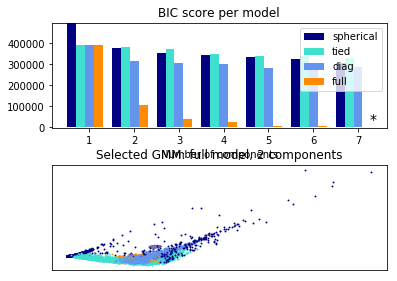

In [18]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
X=reduced_data
bic = []
lowest_bic = np.infty
n_components_range = range(1, 8)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


#Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [19]:
labels

array([[1.00000000e+00, 2.81474324e-55, 9.02804186e-30, ...,
        6.85500103e-32, 1.72722306e-22, 0.00000000e+00],
       [1.00000000e+00, 5.04812745e-31, 4.88989564e-31, ...,
        1.23116243e-26, 2.02502218e-21, 0.00000000e+00],
       [1.00000000e+00, 2.96057746e-37, 1.55673983e-32, ...,
        2.31705167e-34, 2.74782118e-22, 0.00000000e+00],
       ...,
       [1.00000000e+00, 6.81802486e-44, 8.69215114e-38, ...,
        2.84010315e-29, 2.65214133e-26, 0.00000000e+00],
       [1.00000000e+00, 4.72982862e-50, 5.48178056e-29, ...,
        1.96685005e-28, 3.22197202e-22, 0.00000000e+00],
       [1.00000000e+00, 3.66582702e-52, 3.05187165e-26, ...,
        2.19814219e-26, 3.10318767e-23, 0.00000000e+00]])

In [20]:
labels.shape

(10025, 8)

In [21]:
cluster_score = pd.DataFrame(
    {'0_proba':labels[:,0],
    '1_proba':labels[:,1],
    '2_proba':labels[:,2],
    '3_proba':labels[:,3],
    '4_proba':labels[:,4],
    '5_proba':labels[:,5],
    '6_proba':labels[:,6],
    '7_proba':labels[:,7],})

In [22]:
def order(x):
    x=x.tolist()
    return x.index(max(x))
cluster_score['cluster']=cluster_score.apply(order,axis=1)

score_card=dict(cluster_score['cluster'].value_counts()/10000)
score_card

{0: 0.335,
 1: 0.143,
 2: 0.0492,
 3: 0.0284,
 4: 0.0731,
 5: 0.02,
 6: 0.1463,
 7: 0.2075}

In [23]:
from decimal import Decimal, getcontext

In [24]:
score_ev=lambda x: Decimal(x[0]*score_card[0]+x[1]*score_card[1]+x[2]*score_card[2]+x[3]*score_card[3]+x[4]*score_card[4]+x[5]*score_card[5]+x[6]*score_card[6]+x[7]*score_card[7])
cluster_score['score']=cluster_score.apply(score_ev,axis=1)

In [25]:
rank1=cluster_score.sort_values('score').reset_index()[['index','score']]

In [26]:
rank1=rank1.rename(columns={'index':'ProviderID','score':'score'}).reset_index()
rank1['rank']=rank1['index'].apply(lambda x: x+1)
rank1_final=rank1[['ProviderID','rank']].to_csv('Pro_rank.csv',header=False,index=False)
# df.rename(index=str, columns={"A": "a", "B": "c"})

In [29]:
dfX=pd.read_csv('final_submit.csv',sep='\t')

In [32]:
dfX.to_csv('final_problem2.csv',index=False,header=False)